코인 가격으로 구할떄 참고한 코드

In [ ]:
import pandas as pd 

df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
})

# Create a Series with 3 elements
s = pd.Series([2, 3, 4])

In [ ]:
(df.values.T * s.values).T

In [38]:
# 교수님 별로 관심 없으신듯....
def cross_sectional_momentum_terciles(return_df:pd.DataFrame, 
                                      mktcap_df:pd.DataFrame,
                                      num_of_coin_in_group:int,
                                      return_num = False):
    rtn = return_df.copy()
    mktcap = mktcap_df.copy()
    return_dict = {}
    
    quintile = [1/3, 2/3]
    thresh = rtn.apply(lambda x: np.nanquantile(x,quintile),
                       axis=1)
    t1 = thresh.apply(lambda x: x[0])
    t2 = thresh.apply(lambda x: x[1])
    
    # Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
    first = rtn.apply(lambda x: x <= t1, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    second= rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    third = rtn.apply(lambda x: t2 < x, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
                      
    # 횡단면 코인 개수가 그룹별로  num_of_coin_in_group이 넘는 날짜를 출력하자                  
    num_coin = pd.concat([first.sum(1), second.sum(1), third.sum(1)],
                         axis=1)
    
    slice = num_coin[num_coin > num_of_coin_in_group].dropna(axis=0)
    start_date = slice.index[0]
    print("{}에서부터 수익률을 계산".format(start_date))          
            
    # 그룹별로 시가총액 weight를 계산
    weight_1 = (first * mktcap).loc[start_date:].iloc[:-1].apply(lambda x: x / np.nansum(x), axis=1)
    weight_2 = (second* mktcap).loc[start_date:].iloc[:-1].apply(lambda x: x / np.nansum(x), axis=1)
    weight_3 = (third * mktcap).loc[start_date:].iloc[:-1].apply(lambda x: x / np.nansum(x), axis=1)
    
    rtn1 = ((rtn.loc[start_date:].iloc[:-1] * weight_1.shift(1)).sum(1))
    rtn2 = ((rtn.loc[start_date:].iloc[:-1] * weight_2.shift(1)).sum(1))
    rtn3 = ((rtn.loc[start_date:].iloc[:-1] * weight_3.shift(1)).sum(1))
    
    return_dict["Q1"] = rtn1 
    return_dict["Q2"] = rtn2 
    return_dict["Q3"] = rtn3 

    if return_num:
        return_dict["count"] = num_coin.loc[start_date:].iloc[:-1]
    return return_dict

### Returns을 찍어보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats
from tqdm import tqdm

In [2]:
mktcap = pd.read_pickle("ryu_mktcap.pickle")
price  = pd.read_pickle("ryu_price.pickle")

In [3]:
def draw_return_result(return_df, 
                       freq:str):
    '''return을 주면 결과를 리포트 합니다,
       freq에 Weekly, Daily, 3days 등 넣어줘야함(plot title에 들어감)'''
    fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                             gridspec_kw={'height_ratios': [4, 1, 1]})
    cum_df = (return_df+1).cumprod()
    cum_df.plot(ax=axes[0])
    axes[0].set_title("Cummulative {} returns weighted by marketcap".format(freq))
    axes[0].grid()

    peak = cum_df.cummax()
    drawdown = (cum_df - peak)/peak
    drawdown.plot(ax=axes[1])
    axes[1].set_title("Draw Down")
    axes[1].grid()

    return_df.plot(ax=axes[2])
    axes[2].set_title("{} Returns".format(freq))
    axes[2].grid();


def calculate_cagr(return_df):
    '''수익률 df를 주면 CAGR을 계산합니다'''
    holding_year = (len(return_df) / 52)
    cum = (return_df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    print(f"The CAGR is {cagr:.2%}")
    return cagr

def run_alpha_regression(return_df, mktrtn_df, constant=True):
    '''add_constant : True(Default)/ False'''
    tmp_mktrtn = mktrtn_df.copy()
    # 둘의 time-series를 맞춰줍니다
    idx = return_df.index
    tmp_mktrtn = tmp_mktrtn.loc[idx]
    
    if constant:
        model = OLS(return_df, add_constant(tmp_mktrtn))
    else:
        model = OLS(return_df, tmp_mktrtn)
    result = model.fit()
    return result.summary2()

In [4]:
def cross_sectional_momentum_quintile_weekly(weekly_rtn:pd.DataFrame, 
                                             daily_price:pd.DataFrame,
                                             mktcap_df:pd.DataFrame,
                                             num_of_coin_in_group:int,
                                             return_num = False):
    rtn = weekly_rtn.copy()
    mktcap = mktcap_df.copy()
    daily_rtn = daily_price.pct_change(fill_method=None)
        
    quintile = [0.2, 0.4, 0.6, 0.8]
    thresh = rtn.apply(lambda x: np.nanquantile(x,quintile),
                       axis=1)
    t1 = thresh.apply(lambda x: x[0])
    t2 = thresh.apply(lambda x: x[1])
    t3 = thresh.apply(lambda x: x[2])
    t4 = thresh.apply(lambda x: x[3])
    
    # Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
    q1 = rtn.apply(lambda x: x <= t1, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    q2= rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    q3 = rtn.apply(lambda x: (t2 < x) & (x <= t3), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    q4 =  rtn.apply(lambda x: (t3 < x) & (x <= t4), axis=0) \
                      .replace(True, 1).replace(False, np.nan)
    q5 =  rtn.apply(lambda x: x > t4, axis=0) \
                      .replace(True, 1).replace(False, np.nan)
                      
    # 횡단면 코인 개수가 그룹별로  num_of_coin_in_group이 넘는 날짜를 출력하자                  
    num_coin = pd.concat([q1.sum(1), q2.sum(1), q3.sum(1), 
                          q4.sum(1), q5.sum(1)], axis=1)
    
    slice = num_coin[num_coin >= num_of_coin_in_group].dropna(axis=0)
    start_date = slice.index[0]
    print("{}에서부터 수익률을 계산".format(start_date))          
            
    # 그룹별로 시가총액 weight를 계산
    rtn_dict = {}
    i = 1
    for group_mask in tqdm([q1, q2, q3, q4, q5]):
        masked_mktcap = (group_mask * mktcap).loc[start_date:].iloc[:-1] 
        masked_mktcap_ffill = pd.DataFrame(index=daily_price.index,
                                    columns=daily_price.columns) \
                                    .fillna(masked_mktcap) \
                                    .ffill(limit=6)
        daily_mask = np.sign(daily_price)
        group_weight_daily = (daily_mask * masked_mktcap_ffill) \
                            .apply(lambda x: x / np.nansum(x), axis=1)
        group_rtn = (group_weight_daily.shift(7) * daily_rtn.loc[start_date:].iloc[:-1]).sum(1)
        rtn_dict["Q"+str(i)] = group_rtn
        i +=1

    if return_num:
        rtn_dict["count"] = num_coin.loc[start_date:].iloc[:-1]
    return rtn_dict

In [3]:
# pct를 구해줌
pct = price.pct_change(fill_method=None)
pct_weekly = price.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총 weights 계산
mktcap_weekly = mktcap.resample("W").first()

weight_daily = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
weight_weekly = mktcap_weekly.apply(lambda x: x/ np.nansum(x), axis=1)

# nan처리를 위한 masking 생성
sign_daily = np.sign(price)
sign_weekly = np.sign(price.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
rtn_daily = sign_daily * pct
rtn_weekly = sign_weekly * pct_weekly

In [26]:
# 롤링 리턴은 이렇게 구함 -> 이걸로 모멘텀 계산해서 전략 구현 하면 될 듯!
rolling_rtn = price.rolling(window=7, min_periods=7) \
                       .apply(lambda x: (x[-1] - x[0]) / x[0])

Daily 리밸런싱 구현해보자

In [4]:
rtn_daily

,$ROPE,0XBTC,0XMR,0XW,100x,10MT,10SET,18C,1AI,1AMD,...,ZZC,ZZZ,ZZZV2,eCum,eRSDL,g9tro,imBTC,xEUR,yBXTB,yTOFU
2013-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,NaN,-0.006531,NaN,NaN,NaN,NaN,-0.000193,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-03-07,NaN,-0.004959,NaN,NaN,NaN,NaN,0.012862,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-03-08,NaN,-0.006251,NaN,NaN,NaN,NaN,-0.023087,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-03-09,NaN,-0.025372,NaN,NaN,NaN,NaN,-0.017135,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


# 마켓 리턴

In [6]:
# 리턴 계산
## 주간 마켓 리턴
mktrtn_weekly = ((rtn_weekly * weight_weekly.shift(1)).sum(axis=1))

## daily 마켓 리턴
mktrtn_daily = ((rtn_daily * weight_daily.shift(1)).sum(axis=1))

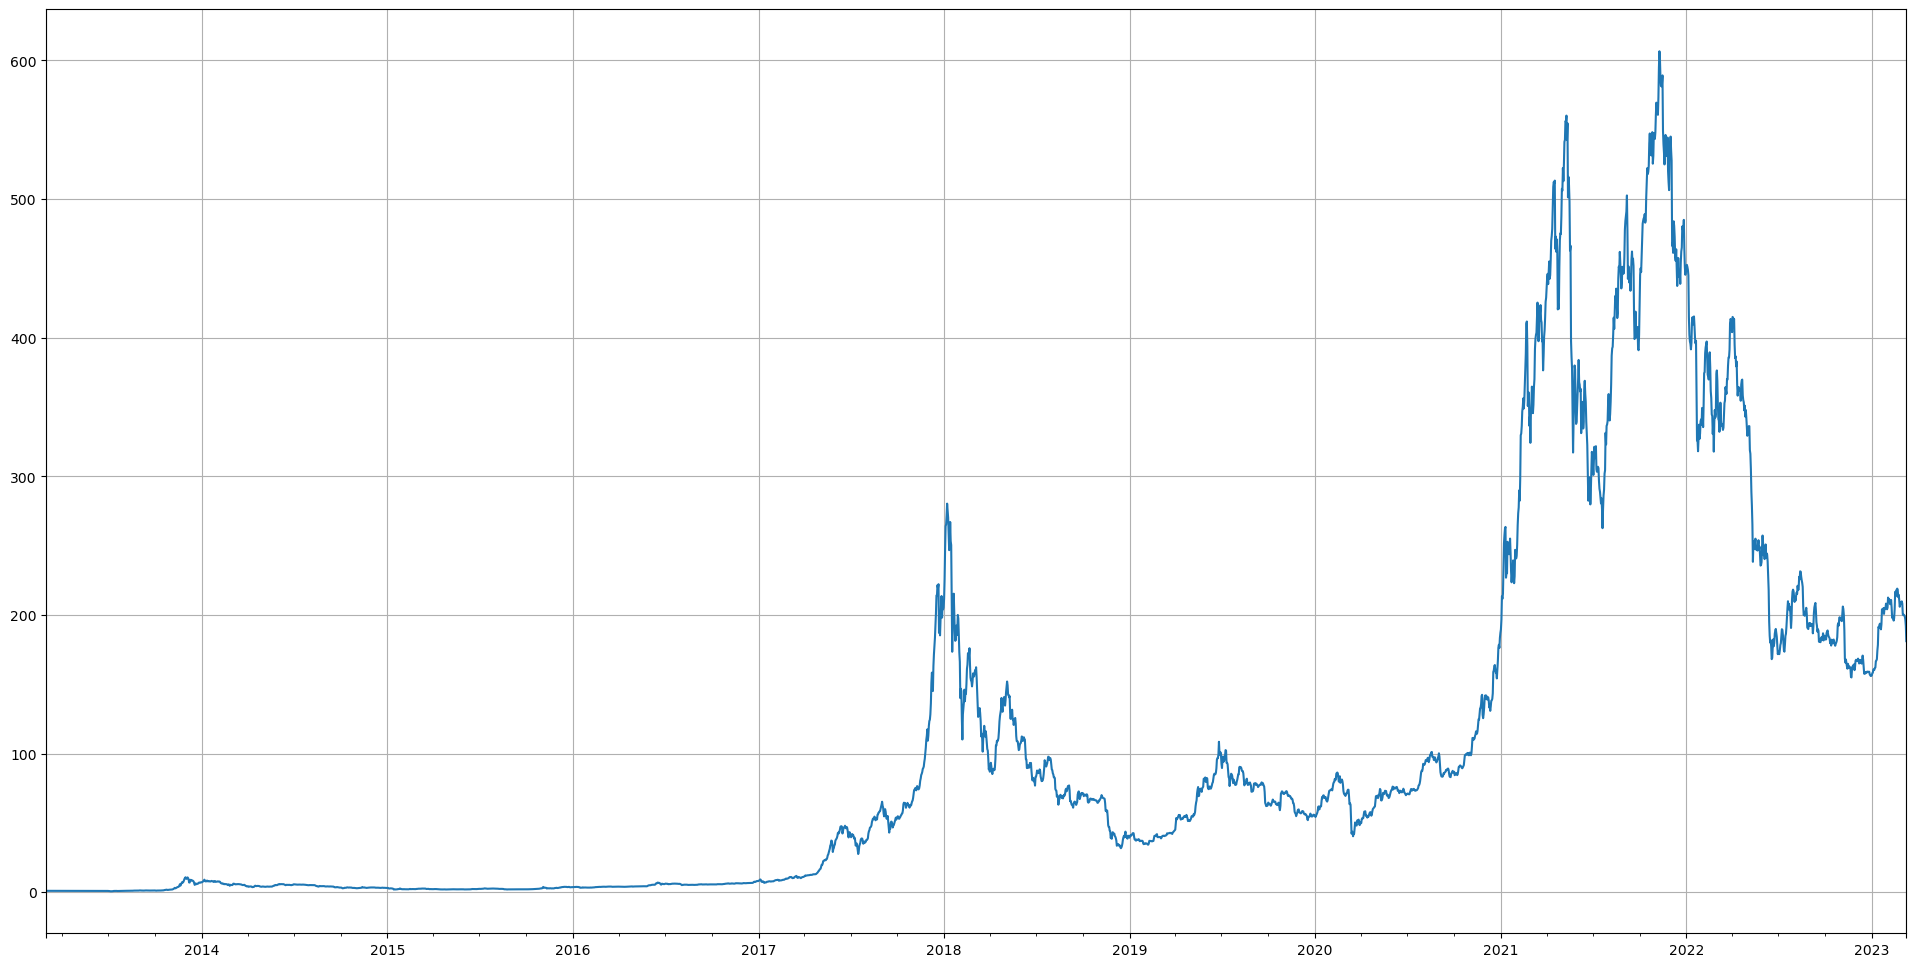

In [9]:
(mktrtn_daily + 1).cumprod().plot(figsize=(24,12))
plt.grid();

In [ ]:
#draw_return_result(mktrtn_weekly, "Weekly")

# 5분위수(모멘텀 기준)

In [80]:
five_group_weekly = cross_sectional_momentum_quintile_weekly(rtn_weekly, 
                                                      price,
                                                      mktcap_weekly,
                                                      20, True)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


2017-07-09 00:00:00에서부터 수익률을 계산


100%|██████████| 5/5 [01:01<00:00, 12.23s/it]


In [81]:
five_group_weekly.keys()

dict_keys(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'count'])

In [88]:
(five_group_weekly["Q1"]).cumprod().plot(figsize=(24,12))
#plt.grid()

2013-03-01    0.000000
2013-03-02    0.000000
2013-03-03    0.000000
2013-03-04    0.000000
2013-03-05    0.000000
                ...   
2023-03-06   -0.000553
2023-03-07   -0.000411
2023-03-08   -0.000695
2023-03-09   -0.001497
2023-03-10    0.000000
Length: 3662, dtype: float64

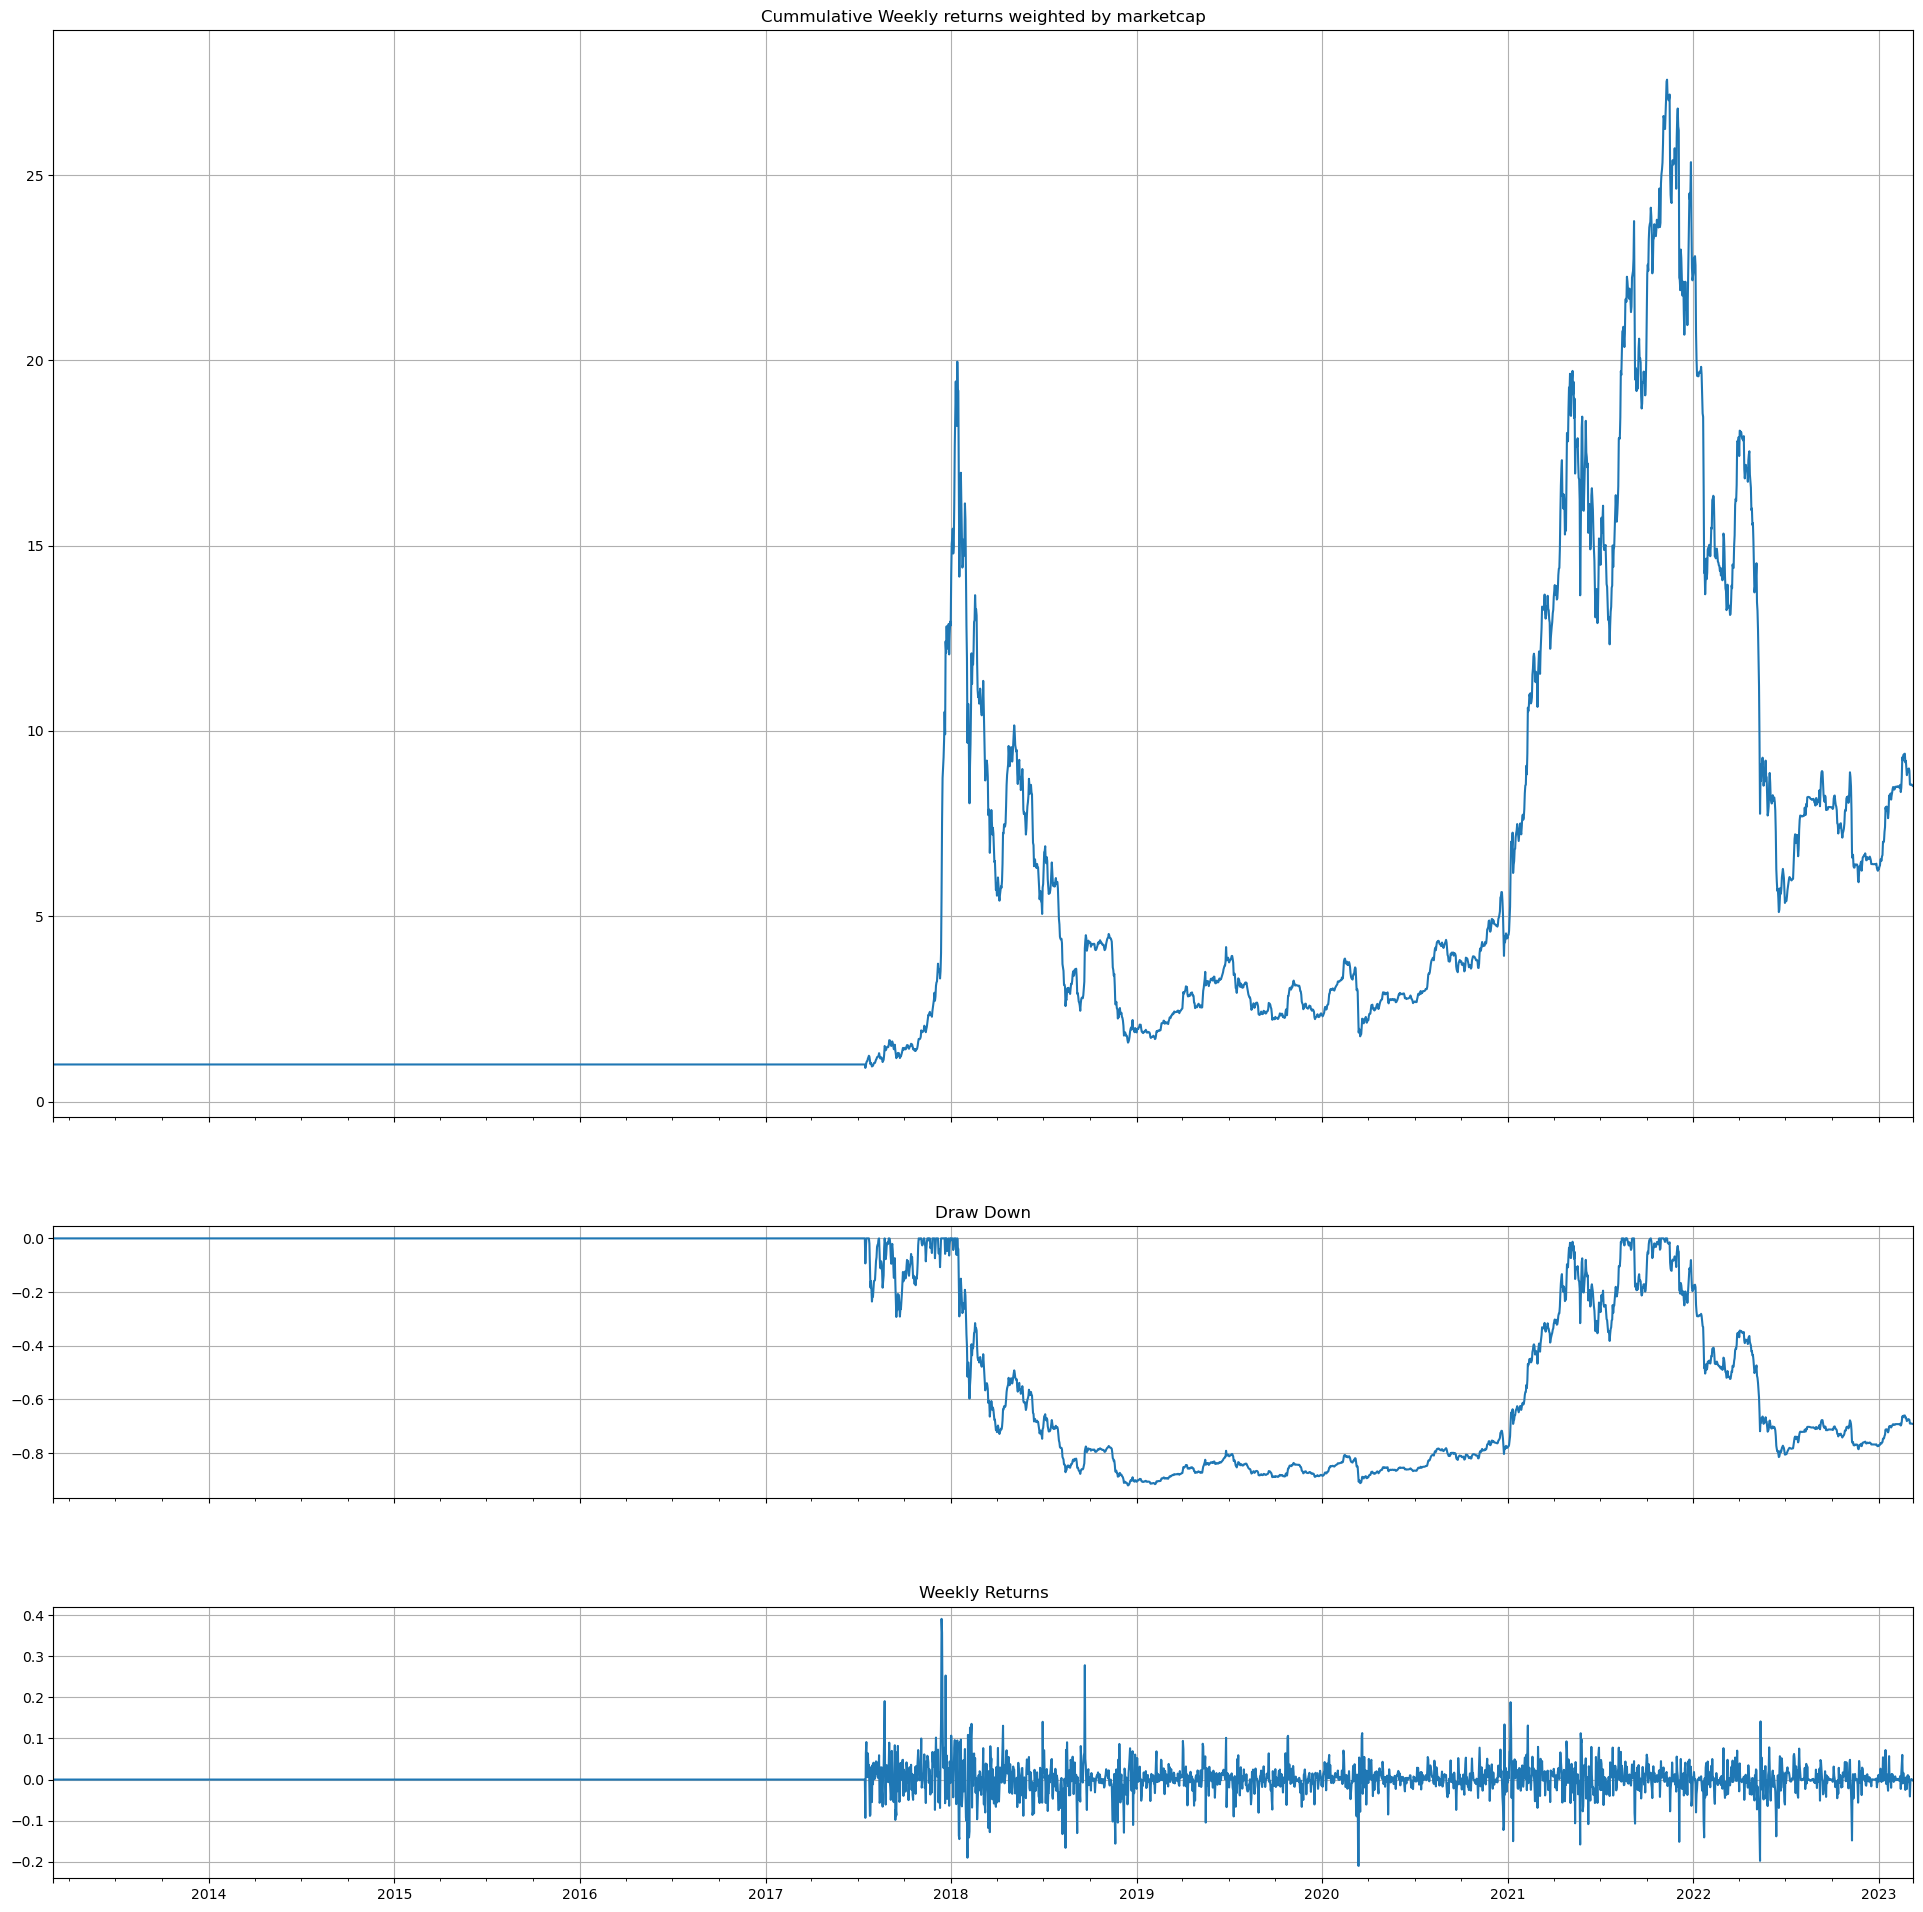

In [102]:
draw_return_result(five_group_weekly["Q2"], freq="Weekly")

In [ ]:
# loc[:"2018"]을 없애면 포폴이 음수를 찍는 날이 나온다
q5q1 = (five_group_weekly["Q5"] - five_group_weekly["Q1"])
#draw_return_result(q5q1, "Daily")

통계량 찍어보자 / cov_type='HAC',cov_kwds={'maxlags':1}

In [9]:
five_group_weekly["Q1"]

2017-06-11    0.291970
2017-06-18    0.086524
2017-06-25    0.056996
2017-07-02   -0.112491
2017-07-09    0.006934
                ...   
2023-02-05    0.056856
2023-02-12    0.049437
2023-02-19   -0.071851
2023-02-26    0.164346
2023-03-05   -0.003656
Length: 300, dtype: float64

In [22]:
run_alpha_regression(five_group_weekly["Q3"],mktrtn_weekly)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.784    
Dependent Variable: y                AIC:                -843.2443
Date:               2023-03-25 16:13 BIC:                -835.8368
No. Observations:   300              Log-Likelihood:     423.62   
Df Model:           1                F-statistic:        1085.    
Df Residuals:       298              Prob (F-statistic): 2.57e-101
R-squared:          0.784            Scale:              0.0034988
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const       -0.0003     0.0034   -0.0827   0.9341   -0.0070   0.0065
0            1.0448     0.0317   32.9337   0.0000    0.9823   1.1072
------------------------------------------------------------------
Omnibus:              217.941      Durbin-Watson:         1.609   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      4796.229
Skew:                 2.638        Prob(JB):              0.000   
Kurtosis:             21.864       Condition No.:         9       
==================================================================

"""

# 3분위수로 계산

In [ ]:
terciles_result = cross_sectional_momentum_terciles(rtn_daily, mktcap,
                                                    19, True)

In [ ]:
terciles_result["count"]

In [ ]:
draw_return_result(terciles_result["Q3"], "Daily")

In [ ]:
terciles_result['count']

In [ ]:
model = OLS(rtn5, 
            add_constant(result1.loc[start_date:] \
                                .iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date:].iloc[:-1],
            rtn2)
plt.xlabel("MKT Return")
plt.ylabel("Return of Q5");

In [ ]:
model = OLS(rtn_s, 
            add_constant(result1.loc[start_date2:].iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date2:].iloc[:-1],
            rtn_h)
plt.xlabel("MKT Return")
plt.ylabel("Return of H");
#plt.ylim(-0.7,1.5);

In [ ]:
mkt_sample = result1.loc[start_date:].iloc[:-1]

In [ ]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("G1:", rtn1.mean().round(4), rtn1.std(ddof=1))
print("G2:", rtn2.mean().round(4), rtn2.std(ddof=1))
print("G3:", rtn3.mean().round(4), rtn3.std(ddof=1))
print("G4:", rtn4.mean().round(4), rtn4.std(ddof=1))
print("G5:", rtn5.mean().round(4), rtn5.std(ddof=1))

t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)
t, p_val

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn1)
calculate_cagr(rtn2)
calculate_cagr(rtn3)
calculate_cagr(rtn4)
calculate_cagr(rtn5)

In [ ]:
concat_df = pd.concat([rtn1, rtn2, rtn3, rtn4 , rtn5, mkt_sample], 
                      axis=1)
concat_df.columns = ["One","Two","Three","Four","Five","MKT"]

concat_df.corr()

In [ ]:
# 3개 그룹의 결과를 뽑자
mkt_sample2 = result1.loc[start_date2:].iloc[:-1]
rtn_s_sample = rtn_s.loc[start_date2:]
rtn_m_sample = rtn_m.loc[start_date2:]
rtn_h_sample = rtn_h.loc[start_date2:]

In [ ]:
print("S:", rtn_s_sample.mean().round(4), rtn_s_sample.std(ddof=1))
print("M:", rtn_m_sample.mean().round(4), rtn_m_sample.std(ddof=1))
print("H:", rtn_h_sample.mean().round(4), rtn_h_sample.std(ddof=1))

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample2)

print("----------------")
print("Group Return")
calculate_cagr(rtn_s_sample)
calculate_cagr(rtn_m_sample)
calculate_cagr(rtn_h_sample)

In [ ]:
concat_df2 = pd.concat([rtn_s_sample, rtn_m_sample,
                        rtn_h_sample, mkt_sample2], 
                       axis=1)
concat_df2.columns = ["Low","Middle","High","MKT"]

concat_df2.corr()

In [ ]:
t, p_val = stats.ttest_ind(rtn_m_sample, 
                           rtn_h_sample)
t,p_val

In [ ]:
model = OLS(rtn_h_sample, 
            add_constant(mkt_sample2))
                            
model.fit().summary2()

In [ ]:
(result1.loc[start_date2:].iloc[:-1] +1)\
    .cumprod().plot(figsize=(24,12), label="Strategy")
(mkt_sample +1).cumprod().plot(figsize=(24,12),
                               label="MKT")
plt.legend();

* Long-Short 전략

코인 롱숏은 숏 한방을 얻어 맞고 죽는듯.....